In [1]:
#Kaggle import and file download
#import kaggle
#from kaggle.api.kaggle_api_extended import KaggleApi

#api = KaggleApi()
#api.authenticate()
#api.dataset_download_files('praveengovi/emotions-dataset-for-nlp')

In [2]:
#import zipfile
#with zipfile.ZipFile('emotions-dataset-for-nlp.zip', 'r') as zip_ref:
    #zip_ref.extractall('emotions-dataset')

In [40]:
#imports
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [2]:
#Remove stopwords and nonalphabetic characters
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(sentence):
    words = word_tokenize(sentence.lower())
    filtered_words = [word for word in words if word.isalpha() and not word in stop_words]
    return ' '.join(filtered_words)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cafes\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cafes\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Helper function to load files
def load_files(filepath):
    text = []
    label = []
    
    with open(filepath, 'r') as file:
        for line in file:
            part = line.strip().split(';')
            if len(part) == 2:
                filtered_text = preprocess_text(part[0])
                text.append(filtered_text)
                label.append(part[1])
    return text, label

train_text, train_label = load_files('emotions-dataset/train.txt')
test_text, test_label = load_files('emotions-dataset/test.txt')
val_text, val_label = load_files('emotions-dataset/val.txt')

In [4]:
train_df = pd.DataFrame({'texts': train_text, 'labels': train_label})
test_df = pd.DataFrame({'texts': test_text, 'labels': test_label})
val_df = pd.DataFrame({'texts': val_text, 'labels': val_label})

df = pd.concat([train_df, test_df, val_df])

In [5]:
df.head()

,texts,labels
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger


In [6]:
df.labels.value_counts()

joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: labels, dtype: int64

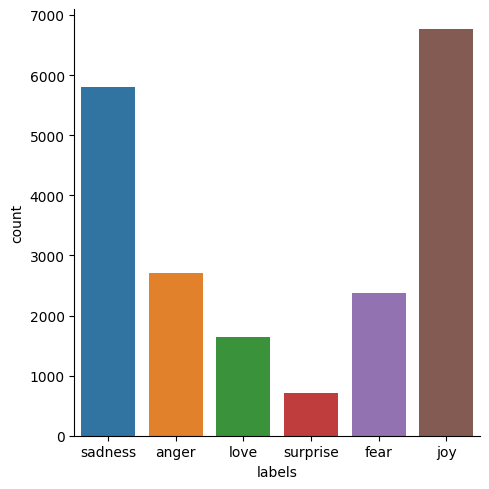

In [7]:
sns.catplot(df, x='labels', kind='count')

Transform to Numeric

In [21]:
train_df.describe()

,texts,labels
count,16000,16000
unique,15879,6
top,feel wronged,joy
freq,5,5362


In [38]:
vect = TfidfVectorizer()
X = vect.fit_transform(train_df.texts)
y = train_df.labels
emotions_transformed = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
print(emotions_transformed.shape)
print(y.shape)

(16000, 15044)
(16000,)


Train Model

In [43]:
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', RandomForestClassifier())
])

# Use GridSearchCV for hyperparameter tuning
param_grid = {
    'vectorizer__max_features': [1000, 5000],
    'classifier__n_estimators': [100, 200],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(train_df['texts'], train_df['labels'])

# Validate the model
val_predictions = grid_search.predict(val_df['texts'])
print("Validation Results:")
print(classification_report(val_df['labels'], val_predictions))

# Test the final model
test_predictions = grid_search.predict(test_df['texts'])
print("Test Results:")
print(classification_report(test_df['labels'], test_predictions))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END classifier__n_estimators=100, vectorizer__max_features=1000; total time=   6.6s
[CV] END classifier__n_estimators=100, vectorizer__max_features=1000; total time=   6.5s
[CV] END classifier__n_estimators=100, vectorizer__max_features=1000; total time=   6.8s
[CV] END classifier__n_estimators=100, vectorizer__max_features=5000; total time=   9.0s
[CV] END classifier__n_estimators=100, vectorizer__max_features=5000; total time=   8.8s
[CV] END classifier__n_estimators=100, vectorizer__max_features=5000; total time=   9.2s
[CV] END classifier__n_estimators=200, vectorizer__max_features=1000; total time=  13.3s
[CV] END classifier__n_estimators=200, vectorizer__max_features=1000; total time=  13.1s
[CV] END classifier__n_estimators=200, vectorizer__max_features=1000; total time=  13.5s
[CV] END classifier__n_estimators=200, vectorizer__max_features=5000; total time=  18.3s
[CV] END classifier__n_estimators=200, vectorizer_